In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Getting Started

Working with stringdale Involves two steps:

* Defining a diagram schema
* Running the a diagram instance

Lets look at an example step by step.

Let us first define some helper functions and function objects:

In [ ]:
def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

And export our basic building blocks

In [ ]:
from stringdale.diagrams import (
    Define,
    V,
    E,
)

## Defining Diagrams

We define a diagram as follows:

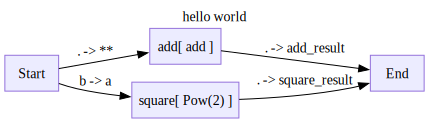

In [ ]:
with Define('hello world',direction='LR') as Schema:
    # each node has a name and an optional function
    V('Start')
    V('add',add)
    V('square',Pow(2))
    # nodes that have no function are called "pass through" nodes
    # they simply collect outputs passed to them into a dict
    V('End')

    # we can define edges using the E function
    # edges are defined via a 'source->target(port_mapping)' syntax
    E('Start->square(a=b)')
    # you can learn more about port mapping in the port mapping section
    E('Start->add(**=.)')
    E('add->End(add_result=.)')
    E('square->End(square_result=.)')

# by default, the diagram is drawn once we finisehd defining it

Alternatively, we can define incoming and outgoing edges within the node definition

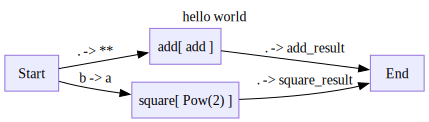

In [ ]:
with Define('hello world',direction='LR') as Schema:
    # Start and End are created automatically as pass through nodes if not defined otherwise

    V('add',add,inputs=['Start(**=.)'],outputs=['End(add_result=.)'])
    V('square',Pow(2),inputs=['Start(a=b)'],outputs=['End(square_result=.)'])

Or

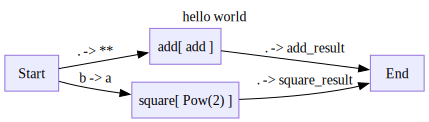

In [ ]:
with Define('hello world',direction='LR') as Schema:
    V('Start',outputs=['add(**=.)','square(a=b)'])
    V('End',inputs=['add(add_result=.)','square(square_result=.)'])
    V('add',add)
    V('square',Pow(2))

We now have a `DiagramSchema` object

In [ ]:
Schema

<stringdale.diagrams.DiagramSchema>

Which we can use to instantiate a new diagram.

In [ ]:
d = Schema()
d

<stringdale.diagrams.Diagram>

## Running Diagrams

We can run diagrams end-to-end like so:

In [ ]:
d.run_all({'a':1,'b':2})

{'square_result': 4, 'add_result': 3}

but in most cases, we would like to monitor the traces of each nodes, which is why we usually run it like so:

In [ ]:
d=Schema()
for trace in d.run({'a':1,'b':2}):
    # put here any side affect you want
    trace.pprint()

Node Start:
{'input': {'a': 1, 'b': 2}, 'output': {'a': 1, 'b': 2}}
Node square:
{'input': {'a': 2}, 'output': 4}
Node add:
{'input': {'a': 1, 'b': 2}, 'output': 3}
Node End:
{ 'input': {'add_result': 3, 'square_result': 4},
  'output': {'add_result': 3, 'square_result': 4}}


Accessing the output via the output attribute of our diagram

In [ ]:
d.output

{'square_result': 4, 'add_result': 3}

stringdale works with transparently with both sync and async functions.
For example:

In [ ]:
import time
import timeit
import asyncio

In [ ]:
async def async_add(a,b):
    await asyncio.sleep(0.1)
    return a+b

class AsyncPow():
    def __init__(self,power):
        self.power = power
    async def __call__(self,a):
        await asyncio.sleep(0.1)
        return a**self.power
    def __str__(self):
        return f'AsyncPow({self.power})'

Can be used exactly the same as the sync versions:

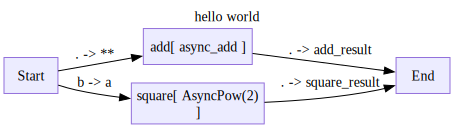

In [ ]:
with Define('hello world',direction='LR') as Schema:
    V('add',async_add,inputs=['Start(**=.)'],outputs=['End(add_result=.)'])
    V('square',AsyncPow(2),inputs=['Start(a=b)'],outputs=['End(square_result=.)'])

In [ ]:

d=Schema()
start_time = timeit.default_timer()
for trace in d.run({'a':1,'b':2}):
    trace.pprint()
end_time = timeit.default_timer()


Node Start:
{'input': {'a': 1, 'b': 2}, 'output': {'a': 1, 'b': 2}}
Node square:
{'input': {'a': 2}, 'output': 4}
Node add:
{'input': {'a': 1, 'b': 2}, 'output': 3}
Node End:
{ 'input': {'add_result': 3, 'square_result': 4},
  'output': {'add_result': 3, 'square_result': 4}}


Note that these functions were run asynchronously

In [ ]:
print(f'Time taken: {end_time-start_time:.2f} seconds')


Time taken: 0.10 seconds


If we want some asynchronous side effects, like logging our traces to our server, for example with this mock class:

In [ ]:
class Logserver():
    def __init__(self):
        self.logs=[]
    async def log(self,trace):
        self.logs.append(trace)
        # time.sleep(0.5)
        await asyncio.sleep(0.1)
        return trace.pretty_name()
        

We can use the asynchronous `arun` method.

In [ ]:
logserver = Logserver()
logs = []

start_time = timeit.default_timer()

async for trace in d.arun({'a':1,'b':2}):
    log_task = logserver.log(trace)
    logs.append(log_task)

res = await asyncio.gather(*logs)

end_time = timeit.default_timer()
res

['Start', 'square', 'add', 'End']

In [ ]:
print(f'Time taken: {end_time-start_time:.2f} seconds')


Time taken: 0.28 seconds


## Drawing Diagrams

We can also draw diagrams directly:

In [ ]:
from stringdale.diagrams import draw_diagram

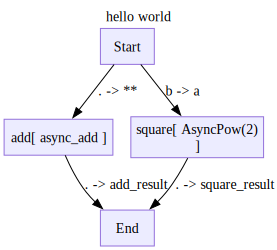

In [ ]:
draw_diagram(Schema,direction='TB')